# Creating a Wordcloud of Your (Work) Life

Summarizing your work manually to a sufficient degree requires some effort, so how about we try to do it automatically to some arbitrary degree?
Here, we'll achieve this goal by first gathering all composed texts (even from recorded oral presentations) as an overview of our work and then creating a stylized summary as a wordcloud.

In [1]:
import os
import collections
from pathlib import Path

import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import nbformat as nbf
from scholarly import scholarly

import webvtt
import youtube_dl

from tqdm.auto import tqdm

## Acquire all composed texts

To create a wordcloud, we first need to acquire all texts which are supposed to be considered.

### Blog posts

We will use all posts from this very blog. They are mostly made up of both Jupyter Notebooks and Markdown entries.

In [2]:
blog_text = ''

for root, dirs, files in os.walk('../'):
    for name in files:
        entry = Path(root) / name

        if entry.suffix == '.ipynb':
            with open(entry) as fd:
                nb = nbf.read(fd, as_version=4)

            for cell in nb['cells']:
                if cell['cell_type'] != 'markdown':
                    continue

                txt = cell['source']

                blog_text += txt
                blog_text += '\n'
        elif entry.suffix == '.md':
            with open(entry) as fd:
                blog_text += fd.read()
                blog_text += '\n'

### Scientific publications

We will also make use of the abstracts of all our published scientific papers.

In [3]:
search_query = list(scholarly.search_author('Kim Philipp Jablonski'))
assert len(search_query) == 1
author = scholarly.fill(search_query[0])

In [4]:
publication_list = []
for pub in tqdm(author['publications']):
    tmp = scholarly.fill(pub)
    publication_list.append(tmp)

  0%|          | 0/15 [00:00<?, ?it/s]

In [5]:
paper_text = ''

for pub in publication_list:
    paper_text += pub['bib']['abstract']
    paper_text += '\n'

### Video presentations

Sure, text is nice. But what about recorded oral presentations?
For this, we can make use of Youtube's automatically generated subtitles.

In [6]:
# some of our talks
video_urls = [
    'https://www.youtube.com/watch?v=eb4mZJdcD7A',
    'https://www.youtube.com/watch?v=gecxYwFtX24',
]

In [7]:
ydl_opts = {
    'writeautomaticsub': True,
    'subtitleslangs': ['en'],
    'skip_download': True,
    'outtmpl': 'subtitle_dir/%(title)s.%(ext)s',
}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(video_urls)

[youtube] eb4mZJdcD7A: Downloading webpage


[youtube] eb4mZJdcD7A: Downloading MPD manifest


[info] Writing video subtitles to: subtitle_dir/Sustainable data analysis with Snakemake.en.vtt


[youtube] gecxYwFtX24: Downloading webpage


[youtube] gecxYwFtX24: Downloading MPD manifest


[info] Writing video subtitles to: subtitle_dir/LauzHack2020 - The Big Auto-ML Showdown.en.vtt


In [8]:
video_text = ''

for entry in os.scandir('subtitle_dir'):
    speech = '\n'.join(
        set(
            row
            for caption in webvtt.read(entry)
            for row in caption.text.strip().splitlines()
        )
    )

    # custom speech-to-text fixes
    speech = speech.replace('snake make', 'snakemake')

    video_text += speech
    video_text += '\n'

### Concatenate text sources

Next, we need to concatenate all text sources.
In order to weight all sources evenly, we will oversample the smaller sources.

In [9]:
text_sources = [blog_text, paper_text, video_text]

In [10]:
token_counts = []
for source in text_sources:
    tokens = source.split(' ')  # poor man's NLP
    token_counts.append(len(tokens))
token_counts

[15157, 2186, 4826]

In [11]:
max_token_count = max(token_counts)

text_factors = []
for tc in token_counts:
    text_factors.append(round(1.5 ** (max_token_count / tc)))
text_factors

[2, 17, 4]

In [12]:
text = ''
for source_text, source_factor in zip(text_sources, text_factors):
    text += source_text.lower() * source_factor  # oversampling
    text += '\n'

### Define reasonable word list to be excluded

To make the wordcloud more interesting and useful, we exclude words which are too common and unspecific.

In [13]:
# TODO: improve this filter
excluded_word_list = set(STOPWORDS)
excluded_word_list.update(
    {
        '',
        'https',
        'value',
        'will',
        'use',
        'using',
        'used',
        'various',
        '{',
        '}',
        'based',
        'number',
        'one',
        '*',
        '-',
        'many',
        'new',
        '=',
        'two',
        'time',
        '1',
        'y',
        'x',
        'find',
        'show',
        'may',
        'first',
        'different',
        'nice',
        'really',
        'basically',
        'make',
        'example',
        'want',
        'need',
        'allows',
        'thing',
        'give',
        'then',
        'something',
    }
)

In [14]:
for word, count in collections.Counter(text.split(' ')).most_common(100):
    if word not in excluded_word_list:
        print(word, count)

data 386
b.1.1.7 204
genomic 191
analysis 187
genetic 187
sequencing 170
sars-cov-2 136
diversity 136
viral 136
distribution 122
snakemake 120
transmission 119
samples 114
python 113
order 112
install 107
statistical 105
surveillance 102
organization 102
mutations 102
variant 102
network 94
run 90


## Plot wordcloud

Finally, we can start plotting!

### Generate mask

To not have the wordcloud in a boring rectangular shape, we will use something more thematic.

In [15]:
width, height = 2000, 600
x, y = np.mgrid[:height, :width]

npdf = norm.pdf(np.linspace(-4, 4, width), 0, 1.3)
npdf /= npdf.max()
pdf_coords = ((1 - npdf) * height).astype(int)

mask = x < pdf_coords
mask = 255 * mask.astype(int)

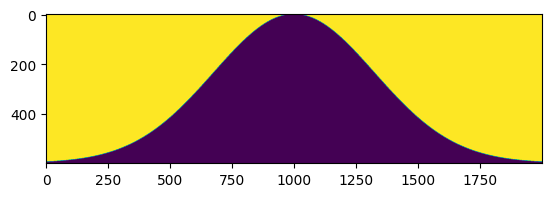

In [16]:
# test outline of mask
plt.imshow(mask)
plt.show()

## Create figure

Here we go!

In [17]:
wordcloud = WordCloud(
    random_state=4242,
    background_color='white',
    min_word_length=3,
    repeat=False,
    mask=mask,
    stopwords=excluded_word_list,
    max_words=250,
    max_font_size=250,
).generate(text)
wordcloud.to_file('wordcloud.png')

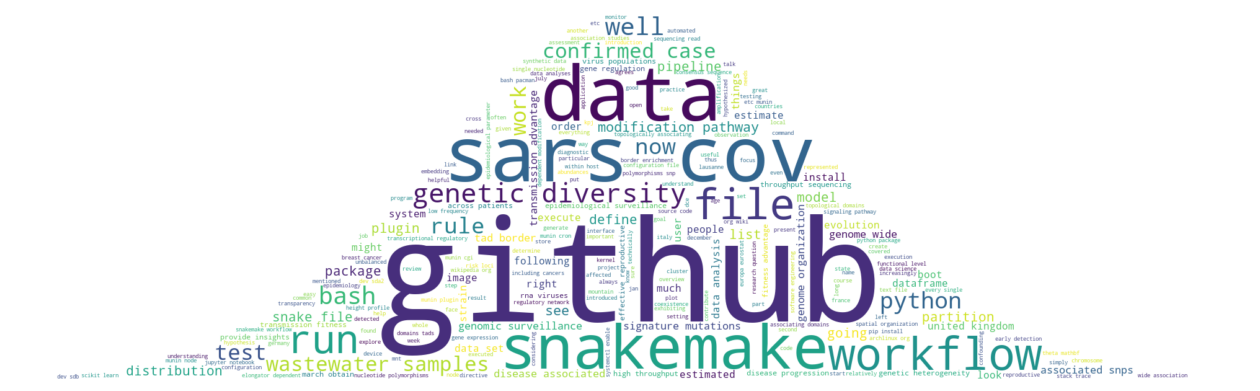

In [18]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')

plt.show()